In [1]:
!pip install -q torch transformers datasets accelerate bitsandbytes scikit-learn matplotlib seaborn numpy pandas tqdm scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 16.3 MB/s eta 0:00:00


In [2]:
import torch

print("CUDA Available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))


CUDA Available: True
GPU: Tesla T4


In [3]:
from datasets import load_dataset

dataset = load_dataset("boolq", split="validation")
dataset = dataset.select(range(500))

calibration_set = dataset.select(range(250))
test_set = dataset.select(range(250, 500))

print(len(calibration_set), len(test_set))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.69M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9427 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3270 [00:00<?, ? examples/s]

250 250


In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_name = "mistralai/Mistral-7B-Instruct-v0.2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config
)

model.eval()


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [9]:
import torch
import numpy as np
import torch.nn.functional as F

def build_prompt(question, passage):
    return f"""
Answer the question using the passage.

Passage:
{passage}

Question:
{question}

Answer:
"""

def get_yes_no_logits(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits[:, -1, :]
    yes_id = tokenizer.encode(" yes", add_special_tokens=False)[0]
    no_id = tokenizer.encode(" no", add_special_tokens=False)[0]
    yes_logit = logits[0, yes_id]
    no_logit = logits[0, no_id]
    return torch.stack([no_logit, yes_logit]).float()

def collect_logits(data_split):
    logits_list = []
    labels = []
    for sample in data_split:
        prompt = build_prompt(sample["question"], sample["passage"])
        logits = get_yes_no_logits(prompt)
        logits_list.append(logits.unsqueeze(0))
        labels.append(1 if sample["answer"] else 0)
    logits_tensor = torch.cat(logits_list).float()
    labels_tensor = torch.tensor(labels).long().cuda()
    return logits_tensor, labels_tensor

def compute_ece(confidences, correctness, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    total = len(confidences)
    for i in range(n_bins):
        indices = [j for j in range(total) if bins[i] <= confidences[j] < bins[i+1]]
        if len(indices) > 0:
            bin_conf = np.mean([confidences[j] for j in indices])
            bin_acc = np.mean([correctness[j] for j in indices])
            weight = len(indices) / total
            ece += abs(bin_acc - bin_conf) * weight
    return ece

def optimize_temperature(logits, labels):
    best_T = 1.0
    best_loss = float("inf")
    nll = torch.nn.CrossEntropyLoss()

    for T in np.linspace(0.5, 20.0, 300):
        scaled_logits = logits / T
        loss = nll(scaled_logits, labels).item()

        if loss < best_loss:
            best_loss = loss
            best_T = T

    return best_T


calib_logits, calib_labels = collect_logits(calibration_set)
T = optimize_temperature(calib_logits, calib_labels)

test_logits, test_labels = collect_logits(test_set)

probs = F.softmax(test_logits, dim=1)
conf = probs.max(dim=1).values.float().cpu().numpy()
pred = probs.argmax(dim=1).long().cpu().numpy()
corr = (pred == test_labels.cpu().numpy()).astype(int)

accuracy = np.mean(corr)
ece_before = compute_ece(conf, corr)

scaled_probs = F.softmax(test_logits / T, dim=1)
scaled_conf = scaled_probs.max(dim=1).values.float().cpu().numpy()
scaled_pred = scaled_probs.argmax(dim=1).long().cpu().numpy()
scaled_corr = (scaled_pred == test_labels.cpu().numpy()).astype(int)

ece_after = compute_ece(scaled_conf, scaled_corr)

print("Optimized Temperature:", round(T,4))
print("Accuracy:", round(accuracy,4))
print("ECE Before:", round(ece_before,4))
print("ECE After:", round(ece_after,4))


Optimized Temperature: 6.8913
Accuracy: 0.812
ECE Before: 0.1588
ECE After: 0.0603


In [10]:
threshold = 0.7

wrong_indices = np.where(corr == 0)[0]
overconf_wrong = np.where((corr == 0) & (conf > threshold))[0]

hallucination_rate = len(wrong_indices) / len(corr)
overconf_hallucination_rate = len(overconf_wrong) / len(corr)

print("\nHallucination Rate:", round(hallucination_rate,4))
print("Overconfident Hallucination Rate:", round(overconf_hallucination_rate,4))



Hallucination Rate: 0.188
Overconfident Hallucination Rate: 0.184


In [11]:
scaled_overconf_wrong = np.where((scaled_corr == 0) & (scaled_conf > threshold))[0]

scaled_overconf_rate = len(scaled_overconf_wrong) / len(scaled_corr)

print("\nOverconfident Hallucination Rate After Scaling:", round(scaled_overconf_rate,4))



Overconfident Hallucination Rate After Scaling: 0.136


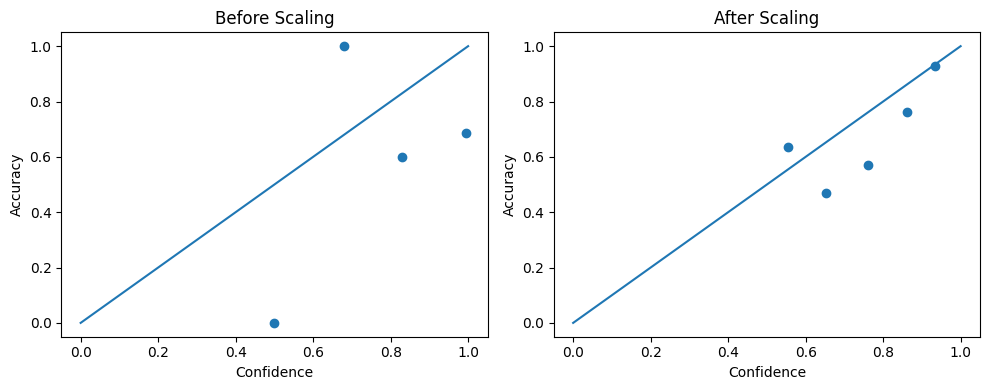

In [12]:
import matplotlib.pyplot as plt

def reliability_data(conf, corr):
    bins = np.linspace(0,1,11)
    bin_conf = []
    bin_acc = []
    for i in range(10):
        idx = [j for j in range(len(conf)) if bins[i] <= conf[j] < bins[i+1]]
        if len(idx) > 0:
            bin_conf.append(np.mean([conf[j] for j in idx]))
            bin_acc.append(np.mean([corr[j] for j in idx]))
    return bin_conf, bin_acc

bc, ba = reliability_data(conf, corr)
sc, sa = reliability_data(scaled_conf, scaled_corr)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot([0,1],[0,1])
plt.scatter(bc, ba)
plt.title("Before Scaling")
plt.xlabel("Confidence")
plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.plot([0,1],[0,1])
plt.scatter(sc, sa)
plt.title("After Scaling")
plt.xlabel("Confidence")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

Self-Reported Mean: 0.9857
Softmax Mean: 0.9898


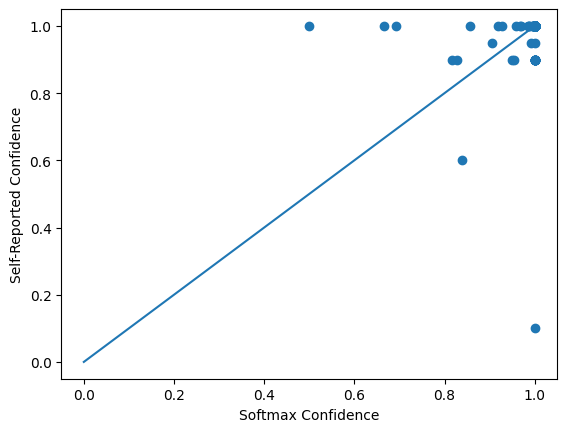

In [13]:
import re

def get_self_report(sample):
    prompt = f"""
Answer the question using the passage.

Passage:
{sample["passage"]}

Question:
{sample["question"]}

Respond strictly in this format:
Answer: <yes or no>
Confidence: <0-100>
"""
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    output = model.generate(**inputs, max_new_tokens=50)
    text = tokenizer.decode(output[0], skip_special_tokens=True)
    match = re.search(r"Confidence:\s*(\d+)", text)
    if match:
        return int(match.group(1))/100
    return None

self_conf = []
soft_conf = []

for i, sample in enumerate(test_set):
    sr = get_self_report(sample)
    if sr is not None:
        self_conf.append(sr)
        soft_conf.append(conf[i])

self_conf = np.array(self_conf)
soft_conf = np.array(soft_conf)

print("Self-Reported Mean:", round(self_conf.mean(),4))
print("Softmax Mean:", round(soft_conf.mean(),4))

plt.figure()
plt.scatter(soft_conf, self_conf)
plt.xlabel("Softmax Confidence")
plt.ylabel("Self-Reported Confidence")
plt.plot([0,1],[0,1])
plt.show()


In [14]:
from scipy.stats import pearsonr

corr_coef, p_val = pearsonr(soft_conf, self_conf)

print("Correlation (Softmax vs Self-Report):", round(corr_coef,4))
print("p-value:", p_val)

mae = np.mean(np.abs(soft_conf - self_conf))
print("Mean Absolute Difference:", round(mae,4))


Correlation (Softmax vs Self-Report): 0.1019
p-value: 0.1257286760177296
Mean Absolute Difference: 0.02


In [15]:
self_corr = corr[:len(self_conf)]

ece_self = compute_ece(self_conf, self_corr)
ece_soft = compute_ece(soft_conf, self_corr)

print("ECE Softmax:", round(ece_soft,4))
print("ECE Self-Reported:", round(ece_self,4))


ECE Softmax: 0.1101
ECE Self-Reported: 0.0143


In [16]:
brier_soft = np.mean((soft_conf - self_corr)**2)
brier_self = np.mean((self_conf - self_corr)**2)

print("Brier Softmax:", round(brier_soft,4))
print("Brier Self-Reported:", round(brier_self,4))


Brier Softmax: 0.1883
Brier Self-Reported: 0.1945


In [17]:
mask = soft_conf < 0.95

filtered_soft = soft_conf[mask]
filtered_self = self_conf[mask]
filtered_corr = self_corr[mask]

print("Filtered size:", len(filtered_soft))

print("Filtered ECE Soft:", compute_ece(filtered_soft, filtered_corr))
print("Filtered ECE Self:", compute_ece(filtered_self, filtered_corr))


Filtered size: 11
Filtered ECE Soft: 0.2018683823672208
Filtered ECE Self: 0.0681818181818182


In [18]:
def adaptive_ece(conf, corr, n_bins=10):
    order = np.argsort(conf)
    conf_sorted = conf[order]
    corr_sorted = corr[order]
    bins = np.array_split(np.arange(len(conf)), n_bins)
    ece = 0.0
    for b in bins:
        if len(b) > 0:
            bin_conf = np.mean(conf_sorted[b])
            bin_acc = np.mean(corr_sorted[b])
            weight = len(b) / len(conf)
            ece += abs(bin_acc - bin_conf) * weight
    return ece

adaptive_before = adaptive_ece(conf, corr)
adaptive_after = adaptive_ece(scaled_conf, scaled_corr)

print("Adaptive ECE Before:", round(adaptive_before,4))
print("Adaptive ECE After:", round(adaptive_after,4))


Adaptive ECE Before: 0.1777
Adaptive ECE After: 0.068


In [19]:
nll_loss = torch.nn.CrossEntropyLoss()

nll_before = nll_loss(test_logits, test_labels).item()
nll_after = nll_loss(test_logits / T, test_labels).item()

print("NLL Before:", round(nll_before,4))
print("NLL After:", round(nll_after,4))


NLL Before: 1.9041
NLL After: 0.4283


In [20]:
def bootstrap_ece(conf, corr, scaled_conf, scaled_corr, n_boot=1000):
    reductions = []
    n = len(conf)
    for _ in range(n_boot):
        idx = np.random.choice(n, n, replace=True)
        e1 = compute_ece(conf[idx], corr[idx])
        e2 = compute_ece(scaled_conf[idx], scaled_corr[idx])
        reductions.append(e1 - e2)
    return np.percentile(reductions, [2.5, 50, 97.5])

ci = bootstrap_ece(conf, corr, scaled_conf, scaled_corr)

print("ECE Reduction 95% CI:", np.round(ci,4))


ECE Reduction 95% CI: [0.0593 0.0893 0.116 ]


In [22]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
import torch

phi_name = "microsoft/phi-2"

phi_tokenizer = AutoTokenizer.from_pretrained(phi_name)
phi_tokenizer.pad_token = phi_tokenizer.eos_token

phi_config = AutoConfig.from_pretrained(phi_name)
phi_config.pad_token_id = phi_tokenizer.eos_token_id

phi_model = AutoModelForCausalLM.from_pretrained(
    phi_name,
    config=phi_config,
    device_map="auto",
    torch_dtype=torch.float16
)

phi_model.eval()


Loading weights:   0%|          | 0/453 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560, padding_idx=50256)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (rotary_emb): PhiRotaryEmbedding()
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (final_layernorm): Layer

In [24]:
import torch.nn.functional as F
import numpy as np

def phi_logits(prompt):
    inputs = phi_tokenizer(prompt, return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = phi_model(**inputs)
    logits = outputs.logits[:, -1, :]
    yes_id = phi_tokenizer.encode(" yes", add_special_tokens=False)[0]
    no_id = phi_tokenizer.encode(" no", add_special_tokens=False)[0]
    yes_logit = logits[0, yes_id]
    no_logit = logits[0, no_id]
    return torch.stack([no_logit, yes_logit]).float()

phi_logits_list = []
phi_labels = []

for sample in test_set:
    prompt = build_prompt(sample["question"], sample["passage"])
    logits = phi_logits(prompt)
    phi_logits_list.append(logits.unsqueeze(0))
    phi_labels.append(1 if sample["answer"] else 0)

phi_logits_tensor = torch.cat(phi_logits_list)
phi_labels_tensor = torch.tensor(phi_labels).long().cuda()

phi_probs = F.softmax(phi_logits_tensor, dim=1)
phi_conf = phi_probs.max(dim=1).values.float().cpu().numpy()
phi_pred = phi_probs.argmax(dim=1).long().cpu().numpy()
phi_corr = (phi_pred == phi_labels_tensor.cpu().numpy()).astype(int)

phi_accuracy = np.mean(phi_corr)
phi_ece = compute_ece(phi_conf, phi_corr)
phi_nll = torch.nn.CrossEntropyLoss()(phi_logits_tensor, phi_labels_tensor).item()

print("Phi-2 Accuracy:", round(phi_accuracy,4))
print("Phi-2 ECE:", round(phi_ece,4))
print("Phi-2 NLL:", round(phi_nll,4))

phi_T = optimize_temperature(phi_logits_tensor, phi_labels_tensor)

phi_scaled_probs = F.softmax(phi_logits_tensor / phi_T, dim=1)
phi_scaled_conf = phi_scaled_probs.max(dim=1).values.float().cpu().numpy()
phi_scaled_pred = phi_scaled_probs.argmax(dim=1).long().cpu().numpy()
phi_scaled_corr = (phi_scaled_pred == phi_labels_tensor.cpu().numpy()).astype(int)

phi_scaled_ece = compute_ece(phi_scaled_conf, phi_scaled_corr)

print("Phi-2 Optimized T:", round(phi_T,4))
print("Phi-2 ECE After:", round(phi_scaled_ece,4))


Phi-2 Accuracy: 0.8
Phi-2 ECE: 0.0524
Phi-2 NLL: 0.4622
Phi-2 Optimized T: 1.3478
Phi-2 ECE After: 0.0322
